In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.signal as signal
import math 

In [2]:
filename = '20230323_bothcaps_marvin_slow'
df_rawdata = pd.read_csv('./data/' + filename + '.csv')
df_rawdata.head() # Check for correct data type
df_rawdata_proto = df_rawdata[df_rawdata["name"] == "Prototype"]
df_rawdata_capno = df_rawdata[df_rawdata["name"] == "Capnostat"]

df_rawdata.head()

,name,type,start_time,duration,data,error
0,Prototype,data,0.001262,0.000989,.,NaN
1,Prototype,data,0.002304,0.000989,º,NaN
2,Prototype,data,0.003345,0.000989,b,NaN
3,Prototype,data,0.004386,0.000989,.,NaN
4,Prototype,data,0.005428,0.000989,.,NaN


In [3]:
# Prep of the Capnostat Data
capno_rawdata = df_rawdata_capno['data']
capno_time = df_rawdata_capno['start_time']

# Convert series data into numpy arrays for ease of manipulation.
capno_cleandata = capno_rawdata.to_numpy(dtype=int)
capno_time = capno_time.to_numpy(dtype=float)


# Remove all negative mmHg values (and respective timestamps) for clinical relevance.
for i in range(0, len(capno_cleandata)):
    capno_cleandata[i] = capno_cleandata[i]/2
    if capno_cleandata[i] <= 0:
        capno_time[i] = -1

capno_cleandata = [value for value in capno_cleandata if value > 0]
capno_time = [value for value in capno_time if value != -1]

# Pass data through a medfilter to clean up periodic impulse signals.
capno_cleandata = signal.medfilt(capno_cleandata)

In [4]:
#Prep of Prototype Data:
result = ""
proto_rawdata = df_rawdata_proto['data']
proto_rawtimes = df_rawdata_proto['start_time']


for index, value in proto_rawdata.items():
    result += value
proto_t_array = proto_rawtimes.to_numpy(dtype=float)
#i was unsure whether result made sense so I printed the first 20 char's
#Print the first 20 characters to see if the result string makes sense:
print("First 20 chars of result: \n"+result[0:20]+"\n end of chars")
#Notice that it outputs a bunch of weird chracters, a new line character, and then some data

#Possible Solution 1:
#we could look for the first newline character, check the distance to the next one, and if its not long enough move onto the next one
#this works because we know our data must at some point go through a \n###,###\n so we can use this as our "base case" and anything outside is random stuff
#it also protects against the case we get two \n's in a row, because we can get random shit at the start of our data and that could could mean \n\n\n

#Possible Solution 3:
#we could just do nothing and hope this works perfectly. I have a feeling this could bite us in the ass later.

# Remove short data from the beginning of the result string.
# Step 1: Remove nonsense (i.e., non-numerical) data from the beginning
numericstart = result[0:result.find(',')].isnumeric()
print("Is the start numeric?: "+str(numericstart))

num_removed = 0 # Number of time values to be removed
while not numericstart:
    result = result.replace(result[0], '', 1)
    num_removed += 1
    print("Result first 20 chars after valid character check: "+result[0:20])
    if result[0:result.find(',')].isnumeric():
        numericstart = True

#Looks like your loop sucessfully removes everything until the first number, which is great!

# Remove respective time values
for i in range(0, num_removed, 1):
    proto_t_array[i] = -1
proto_t_array = [value for value in proto_t_array if value != -1]

# Step 2: Ensure numeric data is valid (i.e., not short) in the beginning
# If invalid, omits data up to and including the next \n and checks again.
properdata = len(result[0:result.find(',')]) == 3
print("Is the data beginning proper? "+str(properdata))
#What if you get this as your input: 1111, 123\n
#its totally possible to get random gibberish at the beginning of transmission so the 1111 is a possible input, so we gotta consider it

num_removed1 = 0 
while not properdata:
    removal = len(result[0:result.find('\n')+1])
    result = result.replace(result[0:result.find('\n')+1], '', 1)
    num_removed1 += removal
    print("Result first 20 chars after valid data check: "+result[0:20])
    if len(result[0:result.find(',')]) == 3: #
        properdata = True

# Remove respective time values
for i in range(0, num_removed1, 1):
    proto_t_array[i] = -1
proto_t_array = [value for value in proto_t_array if value != -1]

properend = result.rfind('\n') == len(result)-1
print("Is the end of this data proper?:" + str(properend))
print("End of the data:" + result[-10:])
#If you look at the end of the data it seems we have an extra CO2 data point but not a nonco2, so we should cut up to that \n before the co2 numbers
num_removed = 0
while not properend:
    removal = len(result) - (result.rfind('\n')+1)
    remove_sub = result[-removal:]
    print("Looking for newline:"+str(result.rfind('\n')+1))
    print("Length to remove:"+str(removal))

    result = result[::-1].replace(remove_sub[::-1], ''[::-1], 1)[::-1]
    num_removed += removal

    if result.rfind('\n') == len(result)-1:
        properend = True
#Lets look at result at the end of the removal:
print("Removed result output:" + str(result[-10:]))


# Remove respective time values
for i in range(len(proto_t_array)-num_removed, len(proto_t_array), 1):
    proto_t_array[i] = -1
proto_t_array = [value for value in proto_t_array if value != -1]

First 20 chars of result: 
.ºb...130,132
128,1
 end of chars
Is the start numeric?: False
Result first 20 chars after valid character check: ºb...130,132
128,13
Result first 20 chars after valid character check: b...130,132
128,131
Result first 20 chars after valid character check: ...130,132
128,131
Result first 20 chars after valid character check: ..130,132
128,131

Result first 20 chars after valid character check: .130,132
128,131
1
Result first 20 chars after valid character check: 130,132
128,131
12
Is the data beginning proper? True
Is the end of this data proper?:False
End of the data:,230
228,
Looking for newline:98712
Length to remove:4
Removed result output:
226,230



In [5]:
# Make a numbers array with each item being (co2, nonco2)
numbers = result.split('\n')
# Deal with any \r that shows up in numbers array
for i in range(0, len(numbers)):
    numbers[i] = str(numbers[i])
    numbers[i] = numbers[i].replace('\r', '')
    # Pop any short data omitted in the previous cell
    if numbers[i] == '':
        numbers.pop(i)
print(numbers)
#Looks like you may have deleted a little too much before, fix the removing from end and I suspect the rest of this will look good

# Define a box signal of length n and height 1/n to use for box filtering
n = 25
filt = np.full(n,1/n)

co2 = []
nonco2 = []
co2_nonco2_diff = []
nonco2_co2_diff= []
ratio = []

co2_filt = []
nonco2_filt = []
co2_nonco2_filt_diff = []
nonco2_co2_filt_diff = []

for i in range(0, len(numbers), 1):
    string = numbers[i].split(',')
    co2.append( 5 * (float(string[0]) / 1024 ))
    nonco2.append( 5 * (float(string[1]) / 1024 ))

# Define prototype timeframe as an array of evenly spaced time values from the first
# recorded prototype timestamp to the last, based on the number of \n from the data
proto_time = np.linspace(proto_t_array[0], proto_t_array[len(proto_t_array)-1], len(co2))
proto_time_filt = []

# Apply the previously defined box filter
co2_filt = np.convolve(co2, filt, 'valid')
nonco2_filt = np.convolve(nonco2, filt, 'valid')

# Define filtered prototype time array based on n
for i in range(0, len(proto_time), 1):
    proto_time_filt.append(proto_time[i])
for i in range(len(proto_time_filt)-(n-1), len(proto_time_filt), 1):
    proto_time_filt[i] = -1
proto_time_filt = [value for value in proto_time_filt if value != -1]

# Calculate differences and ratio (both filtered and unfiltered)
for j in range(0, len(co2), 1):
    co2_nonco2_diff.append(float(co2[j] - nonco2[j]))
    nonco2_co2_diff.append(float(nonco2[j] - co2[j]))
    
for j in range(0, len(co2_filt), 1):
    co2_nonco2_filt_diff.append( float(co2_filt[j] - nonco2_filt[j]) )
    nonco2_co2_filt_diff.append(float(nonco2_filt[j] - co2_filt[j]))
    ratio.append( (float(nonco2_filt[j] - co2_filt[j])) / float(nonco2_filt[j]))


# Phase shift testing, TODO: finalize this code #note: this is DC offset, not phase shift.
#offset = co2[0] - nonco2[0]
#for i in range(0, len(co2), 1):
 #   co2[i] = co2[i] - offset

['130,132', '128,131', '129,131', '128,132', '129,130', '128,132', '129,130', '127,131', '129,131', '126,130', '129,133', '128,131', '130,131', '127,131', '129,131', '128,132', '130,132', '128,132', '130,131', '127,131', '130,131', '128,132', '130,132', '128,131', '130,131', '128,131', '129,131', '127,131', '130,133', '128,131', '130,131', '128,132', '130,132', '128,131', '130,132', '127,129', '129,131', '128,133', '130,132', '128,132', '130,131', '128,131', '130,132', '128,131', '130,132', '128,131', '129,131', '128,131', '129,131', '128,132', '130,131', '128,132', '130,132', '128,131', '129,131', '128,131', '130,131', '127,131', '130,132', '128,132', '130,131', '127,131', '129,131', '127,131', '129,131', '127,131', '129,131', '127,131', '130,132', '128,131', '129,130', '128,132', '129,131', '128,132', '130,131', '128,131', '130,132', '128,131', '129,131', '127,132', '130,131', '128,132', '131,133', '128,131', '130,131', '128,131', '130,131', '128,132', '130,131', '128,130', '129,130'

4564 10968


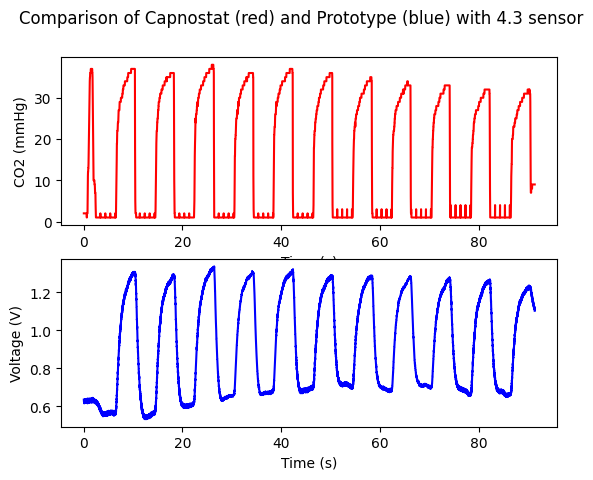

In [11]:
#Plotting Data after Filtering/Processing

fig, axs = plt.subplots(2)
fig.suptitle("Comparison of Capnostat (red) and Prototype (blue) with 4.3 sensor")
axs[0].plot(capno_time, capno_cleandata, color="red")
axs[0].set(xlabel="Time (s)")
axs[0].set(ylabel="CO2 (mmHg)")
axs[1].plot(proto_time, co2, color="blue")
axs[1].set(xlabel="Time (s)")
axs[1].set(ylabel="Voltage (V)")

print(str(len(capno_cleandata)) + " " + str(len(co2_nonco2_diff)))

In [10]:
capno_file = "Data/capnostat_slow.txt"
proto_file = "Data/prototype_slow.txt"

c_fp = open(capno_file, "w")
p_fp = open(proto_file, "w")

c_fp.write(str(len(capno_time)) + "\n")
for i in range(len(capno_time)):
    c_fp.write(str(capno_time[i]) + "," + str(capno_cleandata[i]) + "\n")

p_fp.write(str(len(proto_time)) + "\n")
for i in range(len(proto_time)):
    p_fp.write(str(proto_time[i]) + "," + str(co2[i]) + "\n")

c_fp.close()
p_fp.close()
